<a href="https://colab.research.google.com/github/SARAB0297/Topsis_text_summarization/blob/main/TextSummarizationTopsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install transformers datasets rouge-score torch pandas numpy tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
 

In [18]:
import numpy as np
import pandas as pd
from rouge_score import rouge_scorer
from transformers import pipeline
import torch
import time
import matplotlib.pyplot as plt

# List of candidate models
candidate_models = [
    "facebook/bart-large-cnn",
    "t5-base",
    "google/pegasus-cnn_dailymail",
    "sshleifer/distilbart-cnn-12-6",
    "facebook/bart-large-xsum"
]


In [19]:
# Evaluation criteria with weights
evaluation_criteria = {
    'rouge1_f1': {'weight': 0.25, 'impact': 'positive'},
    'rouge2_f1': {'weight': 0.25, 'impact': 'positive'},
    'rougeL_f1': {'weight': 0.25, 'impact': 'positive'},
    'inference_time': {'weight': 0.15, 'impact': 'negative'},
    'model_size': {'weight': 0.10, 'impact': 'negative'}
}

def fetch_test_data(num_samples=50):
    """Load sample data from CNN/DailyMail dataset"""
    from datasets import load_dataset
    dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")
    return dataset.select(range(num_samples))


Fetching test data...
Assessing models...


Device set to use cuda:0
Assessing facebook/bart-large-cnn: 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Finished assessing facebook/bart-large-cnn


Device set to use cuda:0
Assessing t5-base: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Finished assessing t5-base


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Assessing google/pegasus-cnn_dailymail: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


Finished assessing google/pegasus-cnn_dailymail


Device set to use cuda:0
Assessing sshleifer/distilbart-cnn-12-6: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


Finished assessing sshleifer/distilbart-cnn-12-6


Device set to use cuda:0
Assessing facebook/bart-large-xsum: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Finished assessing facebook/bart-large-xsum
Running TOPSIS...

Final Rankings:
                                                       Model  TOPSIS Score
facebook/bart-large-cnn              facebook/bart-large-cnn      0.799226
sshleifer/distilbart-cnn-12-6  sshleifer/distilbart-cnn-12-6      0.766142
facebook/bart-large-xsum            facebook/bart-large-xsum      0.409801
t5-base                                              t5-base      0.341695
google/pegasus-cnn_dailymail    google/pegasus-cnn_dailymail      0.225625


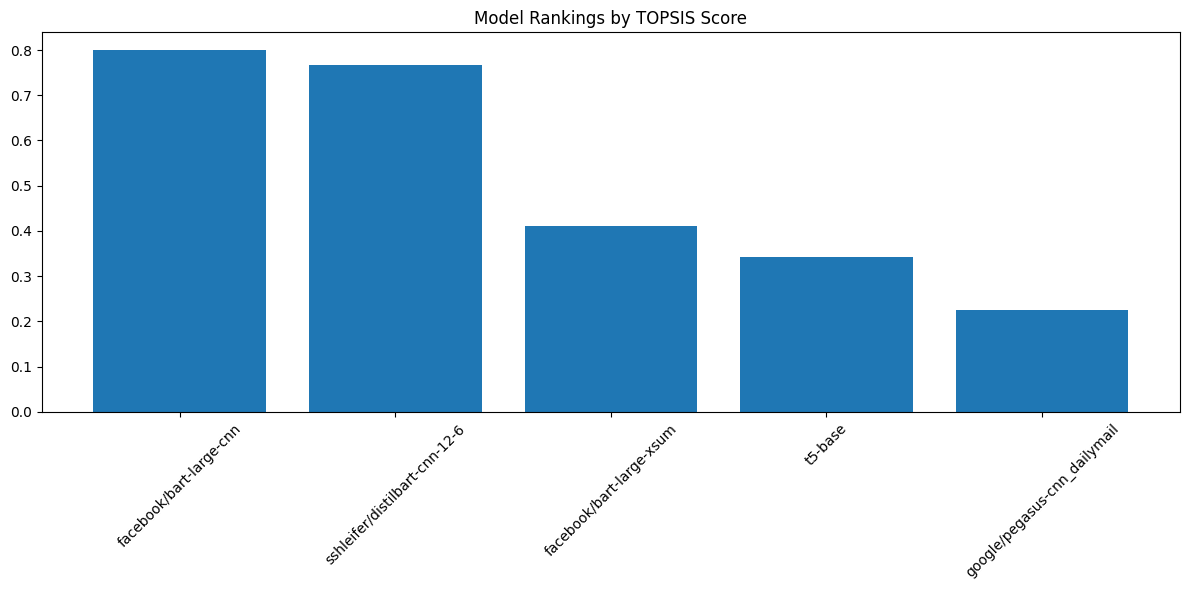

In [20]:
def assess_model(model_name, test_data):
    """Assess a single model on test data"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    summarizer = pipeline("summarization", model=model_name, device=0 if device == "cuda" else -1)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    evaluation_results = {
        'rouge1_f1': [],
        'rouge2_f1': [],
        'rougeL_f1': [],
        'inference_time': [],
        'model_size': []
    }

    # Get model size in MB
    model_size_in_mb = summarizer.model.num_parameters() * 4 / (1024 * 1024)

    for data_item in tqdm(test_data, desc=f"Assessing {model_name}"):
        try:
            start_time = time.time()
            summary = summarizer(data_item['article'][:1024], max_length=130, min_length=30)[0]['summary_text']
            inference_duration = time.time() - start_time

            # Calculate ROUGE scores
            scores = scorer.score(data_item['highlights'], summary)

            evaluation_results['rouge1_f1'].append(scores['rouge1'].fmeasure)
            evaluation_results['rouge2_f1'].append(scores['rouge2'].fmeasure)
            evaluation_results['rougeL_f1'].append(scores['rougeL'].fmeasure)
            evaluation_results['inference_time'].append(inference_duration)
            evaluation_results['model_size'].append(model_size_in_mb)
        except Exception as e:
            print(f"Error with {model_name}: {str(e)}")
            continue

    return {key: np.mean(value) for key, value in evaluation_results.items()}

def execute_topsis(decision_matrix, criteria):
    """Execute TOPSIS method"""
    # Normalize the decision matrix
    normalized = decision_matrix.copy()
    for column in normalized.columns:
        normalized[column] = normalized[column] / np.sqrt((normalized[column]**2).sum())

    # Apply weight multiplication
    for column in normalized.columns:
        normalized[column] = normalized[column] * criteria[column]['weight']

    # Determine ideal best and worst solutions
    ideal_best = []
    ideal_worst = []

    for column in normalized.columns:
        if criteria[column]['impact'] == 'positive':
            ideal_best.append(normalized[column].max())
            ideal_worst.append(normalized[column].min())
        else:
            ideal_best.append(normalized[column].min())
            ideal_worst.append(normalized[column].max())

    # Calculate separation measures
    s_best = np.sqrt(((normalized - ideal_best)**2).sum(axis=1))
    s_worst = np.sqrt(((normalized - ideal_worst)**2).sum(axis=1))

    # Calculate relative closeness
    performance_score = s_worst / (s_best + s_worst)

    return performance_score

# Main execution function
def run_evaluation():
    print("Fetching test data...")
    test_data = fetch_test_data(num_samples=20)  # Using 20 samples for demonstration

    print("Assessing models...")
    model_results = {}
    for model_name in candidate_models:
        try:
            model_results[model_name] = assess_model(model_name, test_data)
            print(f"Finished assessing {model_name}")
        except Exception as e:
            print(f"Error assessing {model_name}: {str(e)}")
            continue

    # Create decision matrix
    decision_matrix = pd.DataFrame(model_results).T

    print("Running TOPSIS...")
    performance_scores = execute_topsis(decision_matrix, evaluation_criteria)

    # Generate final rankings
    rankings = pd.DataFrame({
        'Model': decision_matrix.index,
        'TOPSIS Score': performance_scores
    }).sort_values('TOPSIS Score', ascending=False)

    return rankings, decision_matrix

# Save results and visualizations
def store_results(rankings, decision_matrix):
    # Save rankings to CSV
    rankings.to_csv('final_rankings.csv', index=False)

    # Create visualization
    plt.figure(figsize=(12, 6))
    plt.bar(rankings['Model'], rankings['TOPSIS Score'])
    plt.xticks(rotation=45)
    plt.title('Model Rankings by TOPSIS Score')
    plt.tight_layout()
    plt.savefig('final_rankings.png')

    # Save detailed metrics
    decision_matrix.to_csv('model_performance_metrics.csv')

# Set display options for DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Run the evaluation
rankings, metrics = run_evaluation()

# Display results
print("\nFinal Rankings:")
print(rankings)

# Save results
store_results(rankings, metrics)
